## Семинар 9: "LSTM"

ФИО: Притугин Михаил Алексеевич

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch import optim
import torch
from torch import nn
from torch.autograd import Variable
import pandas
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import StepLR
%matplotlib inline

Этот семинар посвящен реализации RNN в pyTorch

## Задание 1

Напишите свою реализацию LSTM.

<img src="https://cdn-images-1.medium.com/max/1600/1*hl9UVtgIcQkDIGD8VFykdw.png" width="640">

In [2]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.gate_size = 4 * self.hidden_size
        
        self.W_i = nn.Parameter(torch.Tensor(input_size, self.gate_size).zero_())
        
        self.W_h = nn.Parameter(torch.Tensor(hidden_size, self.gate_size).zero_())
        
        self.b = nn.Parameter(torch.Tensor(self.gate_size).zero_())
        
        
    def forward(self, inputs, hidden):
        # inputs: (seq_len, batch_size, input_size)
        # hidden: (batch_size, hidden_size) x 2. (no layers)
        
        h, c = hidden
        bs = h.size(0)
        
        seq_length = inputs.size(0)
        out = Variable(torch.Tensor(seq_length, bs, self.hidden_size))
        
        for i, inp in enumerate(inputs):
            S = (torch.matmul(inp, self.W_i) + torch.matmul(h, self.W_h) + self.b)
            S = S.view(bs, 4, self.hidden_size)
            
            i_1 = torch.sigmoid(S[:,0,:])
            f_1 = torch.sigmoid(S[:,1,:])
            g_1 = torch.tanh(S[:,2,:])
            o_1 = torch.sigmoid(S[:,3,:])
            
            c = f_1 * c + i_1 * g_1
            h = o_1 * torch.tanh(c)
            out[i] = h
        return out, (h, c)

## Задание 2

Используя свою реализацию LSTM и torch.nn.LSTM (torch.nn.GRU) решить задачу предсказания временного ряда.
Попробуйте разные длины входной и выходной последовательности.

Данные о количестве пассажиров
https://datamarket.com/data/set/22u3/international-airline-passengers-monthly-totals-in-thousands-jan-49-dec-60#!ds=22u3&display=line

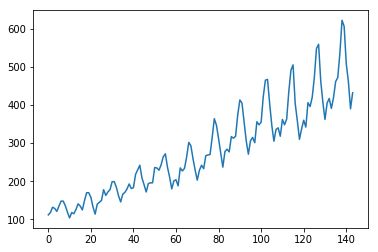

In [3]:
%matplotlib inline
dataset = pandas.read_csv('international-airline-passengers.csv', usecols=[1], delimiter=";", engine='python', skipfooter=3)
plt.plot(dataset)
plt.show()

In [4]:
# подготовливаем данные

dataset = dataset.values
dataset = dataset.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [5]:
# разбиваем данные на train / test
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))


96 48


In [6]:
# Целевая переменная - сдвинутая последовательность значений входов

def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])

    return np.array(dataX), np.array(dataY)

In [7]:
# Пример подготовленных данных

look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [8]:
look_back = 20
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [9]:
class PassengerDataset(Dataset):
    def __init__(self, trainX, trainY):
        self.trainX = trainX
        self.trainY = trainY

    def __len__(self):
        return len(self.trainY)

    def __getitem__(self, idx):
        return self.trainX[idx], self.trainY[idx]
    
train_dataset = PassengerDataset(trainX, trainY)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=64)

test_dataset = PassengerDataset(testX, testY)
test_dataloader = DataLoader(test_dataset, batch_size=64)

In [10]:
class LSTMModel(nn.Module):
    def __init__(self, hidden_dim, num_layers=1):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(1, hidden_dim, num_layers=num_layers)

        self.hidden2out = nn.Sequential(nn.Linear(hidden_dim, 1))

    def forward(self, inp):
        seq_length = inp.size(1)
        batch_size = inp.size(0)
        hidden = (Variable(torch.zeros(self.num_layers, batch_size, self.hidden_dim)).cpu(),
                  Variable(torch.zeros(self.num_layers, batch_size, self.hidden_dim)).cpu())
        inp = pack_sequence(inp)
        
        lstm_out, self.hidden = self.lstm(inp, hidden)
        lstm_out, _ = pad_packed_sequence(lstm_out, False)
        lstm_out = lstm_out[-1]
        
        out = self.hidden2out(lstm_out.view(batch_size, self.hidden_dim))
        return out

In [11]:
def generate(model, n, inputs, batch_first=True):
    result = np.zeros(n + len(inputs))
    result[:len(inputs)] = inputs
    inp = 0
    for i in range(n):
        if batch_first:
            inp = Variable(torch.FloatTensor(result[i:i+len(inputs)])).view(1, len(inputs), 1).cpu()
        else:
            inp = Variable(torch.FloatTensor(result[i:i+len(inputs)])).view(len(inputs), 1, 1).cpu()
        res = lstm(inp)
        result[i + len(inputs)] = res[-1].cpu().data.numpy()
    return result

In [12]:
lstm = LSTMModel(8, 1).cpu()

In [13]:
optimizer = torch.optim.Adam(lstm.parameters(), lr=1e-2)
scheduler = StepLR(optimizer, 1)

In [14]:
from time import time
from torch.nn.utils.rnn import pack_sequence
from torch.nn.utils.rnn import pad_packed_sequence

In [15]:
n_epochs = 1000
loss_f = nn.MSELoss()
start = time()
for reduce in range(3):
    for epoch in range(n_epochs):
        losses = []
        for X, Y in train_dataloader:
            lstm.zero_grad()
            X = Variable(torch.FloatTensor(X)).view(-1, look_back, 1).cpu()
            Y = Variable(torch.FloatTensor(Y)).view(-1, 1).cpu()
            p = lstm(X)
            
            loss = loss_f(p, Y)
            losses.append(loss.data.item())
            loss.backward()
            optimizer.step()
        if epoch % 100 == 0:
            elapsed = time() - start
            print('Эпоха: {}\tОшибка: {:.3e}\tВремя: {:.2f}s'.format(epoch, np.mean(losses), elapsed))
            start = time()
    scheduler.step()

Эпоха: 0	Ошибка: 1.930e-01	Время: 0.03s
Эпоха: 100	Ошибка: 4.229e-03	Время: 2.25s
Эпоха: 200	Ошибка: 3.273e-03	Время: 1.97s
Эпоха: 300	Ошибка: 1.703e-03	Время: 1.82s
Эпоха: 400	Ошибка: 1.749e-03	Время: 2.20s
Эпоха: 500	Ошибка: 1.342e-03	Время: 1.97s
Эпоха: 600	Ошибка: 1.181e-03	Время: 1.59s
Эпоха: 700	Ошибка: 1.055e-03	Время: 1.73s
Эпоха: 800	Ошибка: 1.234e-03	Время: 1.64s
Эпоха: 900	Ошибка: 1.096e-03	Время: 1.65s
Эпоха: 0	Ошибка: 9.475e-04	Время: 1.59s
Эпоха: 100	Ошибка: 9.066e-04	Время: 1.57s
Эпоха: 200	Ошибка: 6.349e-04	Время: 1.66s
Эпоха: 300	Ошибка: 5.255e-04	Время: 1.62s
Эпоха: 400	Ошибка: 7.130e-04	Время: 1.53s
Эпоха: 500	Ошибка: 5.762e-04	Время: 1.60s
Эпоха: 600	Ошибка: 5.353e-04	Время: 1.74s
Эпоха: 700	Ошибка: 2.887e-04	Время: 1.59s
Эпоха: 800	Ошибка: 3.449e-04	Время: 1.63s
Эпоха: 900	Ошибка: 2.945e-04	Время: 1.56s
Эпоха: 0	Ошибка: 1.605e-04	Время: 1.66s
Эпоха: 100	Ошибка: 1.454e-04	Время: 1.57s
Эпоха: 200	Ошибка: 1.447e-04	Время: 1.56s
Эпоха: 300	Ошибка: 1.340e-04	Время: 1.60

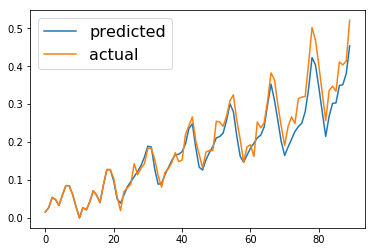

In [16]:
seq = train[:,0]
start = 0
plength = 70
blength = 20
base =  seq[start:start+blength]
predicted = generate(lstm, plength, base)
actual = seq[start:start+plength+blength]
plt.plot(predicted, label='predicted')
plt.plot(actual, label='actual')
plt.legend(fontsize=16)

In [17]:
class LSTMModel(nn.Module):
    def __init__(self, hidden_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim

        self.lstm = LSTM(1, hidden_dim)

        self.hidden2out = nn.Sequential(nn.Linear(hidden_dim, 1))

    def forward(self, inp):
        seq_length = inp.size(0)
        batch_size = inp.size(1)
        hidden = (Variable(torch.zeros(batch_size, self.hidden_dim)).cpu(),
                  Variable(torch.zeros(batch_size, self.hidden_dim)).cpu())
        
        lstm_out, self.hidden = self.lstm(inp, hidden)
        lstm_out = lstm_out[-1]
        
        out = self.hidden2out(lstm_out.view(batch_size, self.hidden_dim))
        return out

In [18]:
lstm = LSTMModel(8).cpu()

In [19]:
optimizer = torch.optim.Adam(lstm.parameters(), lr=1e-1)
scheduler = StepLR(optimizer, 1)

In [20]:
n_epochs = 1000
loss_f = nn.MSELoss()
start = time()
for reduce in range(3):
    for epoch in range(n_epochs):
        losses = []
        for X, Y in train_dataloader:
            lstm.zero_grad()
            X = Variable(X.permute(1,0).unsqueeze(-1)).cpu()
            Y = Variable(Y).cpu()
            p = lstm(X).squeeze()
            
            loss = loss_f(p, Y)
            losses.append(loss.data.item())
            loss.backward()
            optimizer.step()
        if epoch % 100 == 0:
            elapsed = time() - start
            print('Эпоха: {}\tОшибка: {:.3e}\tВремя: {:.2f}s'.format(epoch, np.mean(losses), elapsed))
            start = time()
    scheduler.step()

Эпоха: 0	Ошибка: 3.180e-02	Время: 0.04s
Эпоха: 100	Ошибка: 1.881e-03	Время: 2.28s
Эпоха: 200	Ошибка: 1.830e-03	Время: 2.29s
Эпоха: 300	Ошибка: 1.618e-03	Время: 2.27s
Эпоха: 400	Ошибка: 1.057e-03	Время: 2.23s
Эпоха: 500	Ошибка: 6.832e-04	Время: 2.24s
Эпоха: 600	Ошибка: 7.335e-04	Время: 2.22s
Эпоха: 700	Ошибка: 2.449e-04	Время: 2.20s
Эпоха: 800	Ошибка: 1.964e-04	Время: 3.10s
Эпоха: 900	Ошибка: 1.769e-04	Время: 2.57s
Эпоха: 0	Ошибка: 7.228e-05	Время: 2.05s
Эпоха: 100	Ошибка: 6.369e-04	Время: 2.21s
Эпоха: 200	Ошибка: 6.318e-05	Время: 2.14s
Эпоха: 300	Ошибка: 3.121e-04	Время: 2.23s
Эпоха: 400	Ошибка: 3.708e-05	Время: 2.50s
Эпоха: 500	Ошибка: 8.518e-05	Время: 2.24s
Эпоха: 600	Ошибка: 2.105e-04	Время: 2.07s
Эпоха: 700	Ошибка: 9.466e-05	Время: 2.72s
Эпоха: 800	Ошибка: 7.490e-05	Время: 2.25s
Эпоха: 900	Ошибка: 8.993e-05	Время: 2.29s
Эпоха: 0	Ошибка: 1.199e-04	Время: 2.27s
Эпоха: 100	Ошибка: 1.468e-05	Время: 2.27s
Эпоха: 200	Ошибка: 7.623e-06	Время: 2.30s
Эпоха: 300	Ошибка: 9.451e-06	Время: 2.63

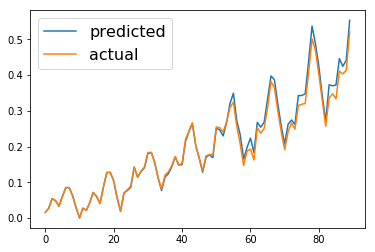

In [21]:
seq = train.reshape(-1)
start = 0
plength = 70
blength = 20
base =  seq[start:start+blength]
predicted = generate(lstm, plength, base, batch_first=0)
actual = seq[start:start+plength+blength]
plt.plot(predicted, label='predicted')
plt.plot(actual, label='actual')
plt.legend(fontsize=16)

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: